In [161]:
from pandas import DataFrame, read_csv
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from numpy import transpose
import numpy as np
from math import sqrt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from time import time
import seaborn as sns
#tf.debugging.set_log_device_placement(True)
print(tf.__version__)

2.0.0


In [162]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
#c = tf.matmul(a, b)

#print(c)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8710583691097918468
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1772421120
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9999183295707708778
physical_device_desc: "device: 0, name: Quadro K2100M, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


In [163]:
X_train_df = read_csv('X_train.csv', index_col=0)
X_val_df = read_csv('X_val.csv', index_col=0)
test_df = read_csv('X_test.csv', index_col=0)
y_train_df = read_csv('y_train.csv', index_col=0)
y_val_df = read_csv('y_val.csv', index_col=0)

### Output scaling

In [164]:
scaler_Y = StandardScaler()
scaler_Y.fit(y_train_df)

y_train = scaler_Y.transform(y_train_df)
y_val = scaler_Y.transform(y_val_df)

In [18]:
y_train = y_train.SalePrice.values.astype(float)
y_val = y_val.SalePrice.values.astype(float)

In [134]:
X_train = transpose([X_train.Surface.values.astype(float)])
X_val = transpose([X_val.Surface.values.astype(float)])

In [165]:
X_train_df.shape

(1049, 178)

In [166]:
#X_train = X_train[['Surface','OverallQual']].values.astype(float)
#X_val = X_val[['Surface','OverallQual']].values.astype(float)
X_train = X_train_df.values.astype(float)
X_val = X_val_df.values.astype(float)
test = test_df.values.astype(float)

In [167]:
nb_features = 24
X_train = X_train[:,:nb_features]
X_val = X_val[:,:nb_features]
test = test[:,:nb_features]

In [ ]:
nb_features = 150
pca = PCA(n_components=nb_features)
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
X_train=pca.transform(X_train)
X_val=pca.transform(X_val)

In [168]:
X_train.shape

(1049, 24)

In [169]:
from tensorflow.keras.backend import sigmoid, tanh, maximum
def custom(x):
    return maximum(x-2,tanh(x-2)+2)

In [170]:
def get_reg_model():
    return Sequential([
                    Input(shape=X_train.shape[1]),
                    Dense(1)
])

In [171]:
def get_other_model():
    return Sequential([
                    Input(shape=X_train.shape[1]),
#                    Activation('relu',activity_regularizer=regularizers.l1(0.0001)),
                    Dense(32, kernel_regularizer=regularizers.l1(0.01)),
                    Activation('relu', activity_regularizer=regularizers.l1(0.001)),
                    Dense(1)
])

In [172]:
def get_better_model():
    model = Sequential()
    model.add(Input(shape=X_train.shape[1:]))
    model.add(Dense(16,
                kernel_initializer='normal',
#                kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l1(0.001),
                activation='relu'
                ))
#model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('relu'))
#    model.add(Activation('relu', activity_regularizer=regularizers.l1(0.001)))
#model.add(tf.keras.layers.PReLU())
    model.add(Dense(1))
#model.add(Activation('elu'))
    return model

In [173]:
loss = 'mse'
LEARNING_RATE = 0.01

In [174]:
model = get_reg_model()
model.compile(loss=loss, optimizer=SGD(lr=LEARNING_RATE))
BATCH_SIZE = X_train.shape[0] # computing the loss over the whole dataset
EPOCHS = 5000 # how many iterations over the whole dataset
t_0 = time()
#with tf.device('/device:GPU:0'):
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

print(time()-t_0, 's')

7.5559375286102295 s


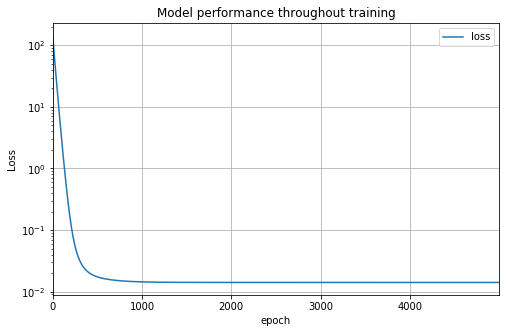

In [714]:
DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [175]:
y_p_scaled = model.predict(X_val)
y_p_scaled = y_p_scaled.reshape(y_p_scaled.shape[0])
y_p = scaler_Y.inverse_transform(y_p_scaled)

RMSLE = sqrt(mean_squared_error(y_val_df,y_p))
print('Validation RMSLE:', RMSLE)
y_p_scaled = model.predict(X_train)
y_p_scaled = y_p_scaled.reshape(y_p_scaled.shape[0])

y_p = scaler_Y.inverse_transform(y_p_scaled)

RMSLE = sqrt(mean_squared_error(y_train_df.SalePrice,y_p))
print('Train RMSLE:', RMSLE)

Validation RMSLE: 0.14941123846518387
Train RMSLE: 0.11872182569898126


In [176]:
test_pred = model.predict(test)
submission = DataFrame({"SalePrice": np.exp(test_pred).reshape(test_pred.shape[0])}, index=test_df.index)
submission.to_csv('test-prediction-keras-lin.csv')

In [177]:
model = get_other_model()

In [178]:
LEARNING_RATE=0.05
model.compile(loss=loss, optimizer=SGD(lr=LEARNING_RATE))
#model.compile(loss=loss, optimizer=RMSprop(lr=LEARNING_RATE))
#model.compile(loss=loss, optimizer=Adam(lr=LEARNING_RATE))

In [179]:
BATCH_SIZE = X_train.shape[0] # computing the loss over the whole dataset
EPOCHS = 20000 # how many iterations over the whole dataset
t_0 = time()
#with tf.device('/device:GPU:0'):
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
print(time()-t_0)

38.70408487319946


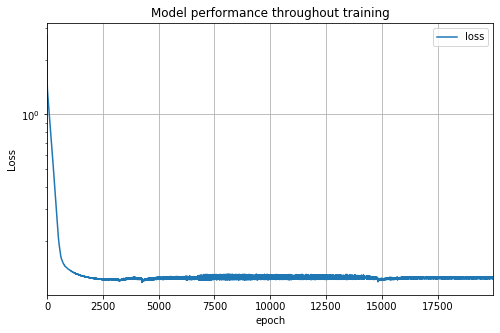

In [180]:
DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [199]:
y_p_scaled = model.predict(X_val)
y_p_scaled = y_p_scaled.reshape(y_p_scaled.shape[0])
y_p_val = scaler_Y.inverse_transform(y_p_scaled)

RMSLE = sqrt(mean_squared_error(y_val_df,y_p_val))
print('Validation RMSLE:', RMSLE)
y_p_scaled = model.predict(X_train)
y_p_scaled = y_p_scaled.reshape(y_p_scaled.shape[0])

y_p_train = scaler_Y.inverse_transform(y_p_scaled)

RMSLE = sqrt(mean_squared_error(y_train_df.SalePrice, y_p_train))
print('Train RMSLE:', RMSLE)

Validation RMSLE: 0.14879673025763918
Train RMSLE: 0.1173625224420965


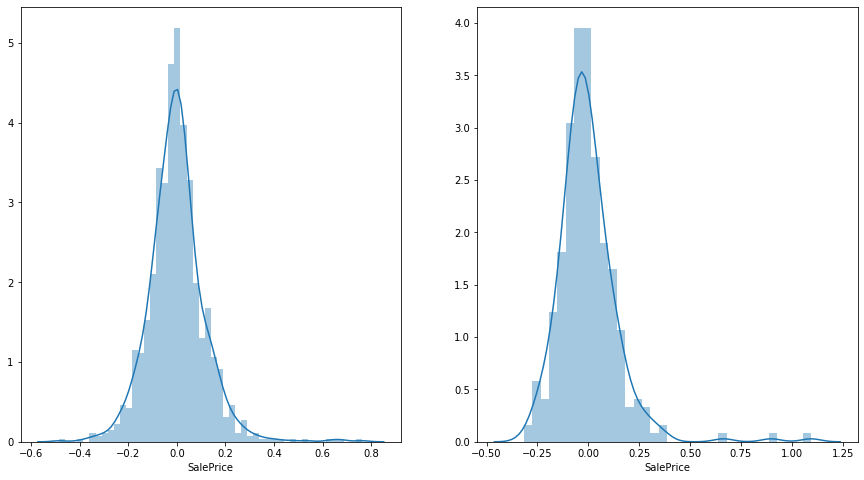

In [200]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.distplot(y_p_train-y_train_df.SalePrice)
plt.subplot(1,2,2)
sns.distplot(y_p_val-y_val_df.SalePrice)
plt.show()

(1049,)


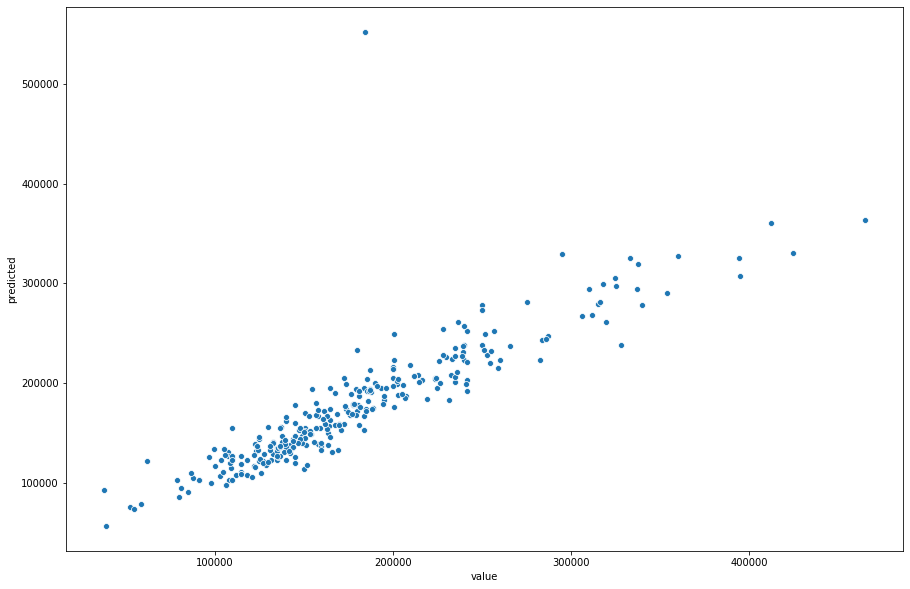

In [213]:
y = y_val_df.SalePrice.to_numpy()
y = y.reshape(y.shape[0])
print(y_p_train.shape)
df = DataFrame(data={'value':np.exp(y), 'predicted':np.exp(y_p_val)})
plt.figure(figsize=(15,10))
sns.scatterplot(x='value',y='predicted', data=df )
plt.show()

In [214]:
anomaly_idx = df['predicted'].idxmax()
print(anomaly_idx)

142


In [215]:
anomaly = X_val_df.iloc[anomaly_idx]

In [216]:
anomaly.loc[np.abs(anomaly)>1.5]

Surface                  6.628896
OverallQual              2.824970
KitchenQual_ord          2.274398
GarageCars               1.634322
SaleType_New             3.301206
GarageArea               1.948454
BsmtExposure_Gd          3.178799
BsmtQual_ord             1.703280
BsmtFinSF1               4.210999
SaleCondition_Partial    3.264966
FullBath                 2.614849
2ndFlrSF                 2.740429
BsmtFinType1_GLQ         1.618987
LotArea                  3.283105
SaleType_WD             -2.592654
LandContour_Lvl         -2.980160
Neighborhood_Edwards     3.734798
1stFlrSF                 5.232092
OpenPorchSF              5.380255
TotalBsmtSF              4.881511
ExterQual_ord            2.807580
GarageType_BuiltIn       3.987299
TotRmsAbvGrd             2.800135
RoofStyle_Hip            2.001073
Condition1_Norm         -2.498447
HouseStyle_2Story        1.517602
SaleCondition_Normal    -2.133631
Exterior1st_CemntBd      4.879397
LotFrontage              3.046534
MasVnrArea    